# Independent study
Find links to the original dataset & paper along with other resources.
- [github link to data](https://github.com/anhender/mse_ML_datasets/blob/v1.0/raw_data/Bala_classification_dataset.csv)
- [original paper](https://www.nature.com/articles/s41467-018-03821-9)
- [data in breif overview](https://www.sciencedirect.com/science/article/pii/S2352340921005461)


In [1]:
# First import some libraries
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Environment
Uncomment the code to create a requirements.txt file in current working directory which you can then pip intall with `pip install -r requirements.txt` <br>
Note: Not all of these packages will be required to run this notebook.

In [2]:
#!pip freeze > requirements.txt # you may need to change 'pip' to 'pip3'

### Loading the data

In [6]:
datapath = './data//Bala_classification_dataset.csv'
df = pd.read_csv(datapath)
display(df.head())

,Compound,x(BiMe1Me2)O3,Me1,Me2,Me3,frac-Me1,frac-Me2,frac-Me3,PT-content,Tolerance_Factor,Valence_Electron_Number,Martynov_Batsanov_Electronegativity,Ideal_Bond_Length_Sum,Mendeleev_Number,Formability
0,Bi(GaSc),0.45,Ga,Sc,Ti,0.25,0.75,0.0,0.55,0.9813,8.0,3.7395,3.9208,118.9375,No
1,Bi(GaSc),0.40,Ga,Sc,Ti,0.25,0.75,0.0,0.60,0.9864,8.0,3.7440,3.9215,119.5000,No
2,Bi(GaSc),0.38,Ga,Sc,Ti,0.25,0.75,0.0,0.62,0.9884,8.0,3.7458,3.9218,119.7250,No
3,Bi(GaSc),0.36,Ga,Sc,Ti,0.25,0.75,0.0,0.64,0.9904,8.0,3.7476,3.9221,119.9500,No
4,Bi(GaSc),0.30,Ga,Sc,Ti,0.25,0.75,0.0,0.70,0.9966,8.0,3.7530,3.9229,120.6250,Yes


In [7]:
# Create a new dataset with binary labels (Formability to -1 and 1)
labels = df.iloc[:,-1]
bin_labels = np.where(labels.values=='Yes',1,-1).astype('float')

In [8]:
data_bin = df.iloc[:,:-1]
data_bin[df.columns[-1]]=bin_labels
data_bin.iloc[:,-6:].head()

,Tolerance_Factor,Valence_Electron_Number,Martynov_Batsanov_Electronegativity,Ideal_Bond_Length_Sum,Mendeleev_Number,Formability
0,0.9813,8.0,3.7395,3.9208,118.9375,-1.0
1,0.9864,8.0,3.7440,3.9215,119.5000,-1.0
2,0.9884,8.0,3.7458,3.9218,119.7250,-1.0
3,0.9904,8.0,3.7476,3.9221,119.9500,-1.0
4,0.9966,8.0,3.7530,3.9229,120.6250,1.0


## Apply methods

### Model 1: SVM classification
#### Model breakdown
Features: tolerance factor, electron number, electronegativity, ideal bond length, mendeleev number <br>
Label: Formability <br><br>
```
For i in range (100):
    1. split data into 40 test samples
    2. train SVC with Radial Basis Function kernel
    3. predict with train set
    4. record accuracy
Take average of the accuracy
```
- [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
- [SVM](https://scikit-learn.org/stable/modules/svm.html)

In [9]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.svm import SVC

In [13]:
def hyper_parameter_gridsearch(X,y):
    parameters = {'C':[0.01,0.1,1,10,100],'gamma':[0.01,0.1,1,10,100]}
    svc = SVC()
    clf = GridSearchCV(svc,parameters,cv=10)
    clf.fit(X,y)
    return clf

def final_model(X,y,params):
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=40,shuffle=True)
    
    # Train SVC
    C = params['C']
    gamma = params['gamma']
    svc = SVC(C=C, gamma=gamma, kernel = 'rbf') # Keep default parameters for now
    svc.fit(X_train,y_train)
    
    # Predict with test set
    pred = svc.predict(X_test)
    
    # record and return accuracy
    wrong = np.count_nonzero(pred-y_test)
    return 1-(wrong/pred.size)

In [14]:
# Define our X and y data
X = data_bin.iloc[:,-6:-1]
y = data_bin.iloc[:,-1]

In [15]:
# Hyperparameter Optimization
clf = hyper_parameter_gridsearch(X,y)

print('best parameters: ',clf.best_params_)
print('best score: ',clf.best_score_)

best parameters:  {'C': 1, 'gamma': 0.1}
best score:  0.7857894736842106


In [16]:
iterations = 100

# Create our model
accuracies = [final_model(X,y,clf.best_params_) for _ in range(iterations)]

In [17]:
print('mean: ',np.mean(accuracies))
print('std: ',np.std(accuracies))

mean:  0.774
std:  0.06284106937345992


### Model 2: Unsupervised / Clustering
Model: [PCA](https://scikit-learn.org/stable/modules/decomposition.html), [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [19]:
# Let's try PCA on the input data

## First normalize the dataset
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [20]:
# Construct model and fit
pca=PCA()
pca.fit(X_scaled)
explained_variance=pca.explained_variance_ratio_
x_transformed = pca.fit_transform(X_scaled)
print('Explained variance ratio:',explained_variance)
cumul_variance = list()
for idx,var in enumerate(explained_variance):
    if idx == 0:
        cumul_variance.append(var)
    else:
        cumul_variance.append(var+cumul_variance[-1])
print('Cumulative explained variance ratio: ',cumul_variance)

Explained variance ratio: [0.4999227  0.26429013 0.12391481 0.06866309 0.04320927]
Cumulative explained variance ratio:  [0.49992270418261986, 0.7642128331932833, 0.8881276467387539, 0.9567907348337472, 1.0]


In [21]:
## Some labelling variables used in plotting
y_names = df['Compound']
x_columns = X.columns
y_color=data_bin.iloc[:,-1]

# formibility indices for plotting
n_ind = np.where(y_color==-1)[0]
y_ind = np.where(y_color==1)[0]

In [22]:
## Helper functions for plotting
## meat of the biplot function was taken from https://stackoverflow.com/questions/39216897/plot-pca-loadings-and-loading-in-biplot-in-sklearn-like-rs-autoplot

def biplot(score,coeff,ax,which,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    # plot positives
    ax.scatter(xs[y_ind] * scalex,ys[y_ind] * scaley,c='b',label="formable")
    # plot negatives
    ax.scatter(xs[n_ind] * scalex,ys[n_ind] * scaley,c='r',label='not formable')
    #for i, txt in enumerate(y_names):
    #    ax.annotate(txt, (xs[i]*scalex, ys[i]*scaley),fontsize=5)
    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, x_columns[i], color = 'g', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_xlabel("PC{}".format(which[0]))
    ax.set_ylabel("PC{}".format(which[1]))
    ax.set_title('biplot')
    ax.legend()
    ax.grid()
    
def loadings_plot(x1,x2,ax,which):
    ax.axhline(0,c='k',alpha=0.5)
    ax.axvline(0,c='k',alpha=0.5)
    ax.scatter(x1,x2)
    for i, txt in enumerate(x_columns):
        ax.annotate(txt,(x1[i],x2[i]),fontsize=10)
    
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_xlabel(f"{which[0]} component loadings [{int(explained_variance[0]*100)}%]")
    ax.set_ylabel(f"{which[1]} component loadings [{int(explained_variance[1]*100)}%]")
    ax.set_title('loadings plot')


def scree_plot(variance,ax):

    ax.bar(list(range(1,len(variance)+1)),variance)
    ax.set_xlabel('Principal Component')
    ax.set_ylabel('Explained Variance Ratio %')
    ax.set_title('Scree plot')
    



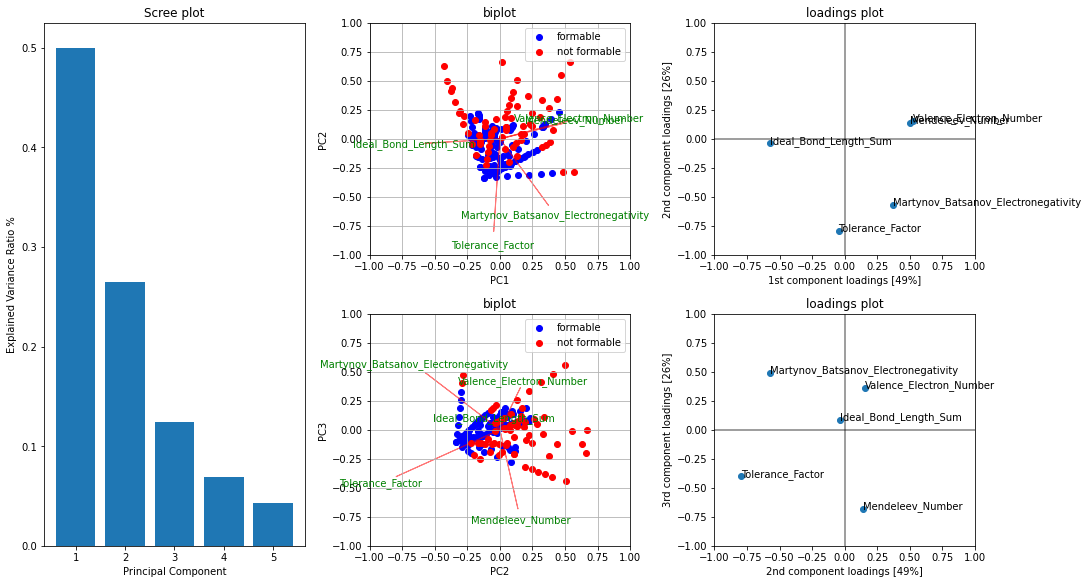

In [23]:
fig,axd=plt.subplot_mosaic([['left','center up', 'upper right'],
                            ['left','center lo', 'lower right']],figsize=(15,8),constrained_layout=True)

# Scree plot
scree_plot(explained_variance,ax=axd['left'])
biplot(x_transformed[:,0:2],np.transpose(pca.components_[0:2, :]),which=[1,2],ax=axd['center up'])
biplot(x_transformed[:,1:3],np.transpose(pca.components_[1:3, :]),which=[2,3],ax=axd['center lo'])
loadings_plot(pca.components_[0],pca.components_[1],ax=axd['upper right'],which=['1st','2nd'])
loadings_plot(pca.components_[1],pca.components_[2],ax=axd['lower right'],which=['2nd','3rd'])
fig.savefig('pca_plot.png',facecolor='white', transparent=False)

#### t-SNE
- Let's try to color our points based on certain feature values to see if we can identify any clusters. We can try:
    1. Formability
    2. Compound
    3. Certain ranges of some of the features

In [24]:
from sklearn.manifold import TSNE

In [25]:
print('Num of unique compounds: ',np.unique(df['Compound']).size)

# normalizing tolerance factor to use in a plot later
data_bin['normalized_tol_factor']=(data_bin['Tolerance_Factor']-np.min(data_bin['Tolerance_Factor']))/(np.max(data_bin['Tolerance_Factor'])-np.min(data_bin['Tolerance_Factor']))

Num of unique compounds:  24


In [27]:
## Let's convert our compounds to unique integers
labels_dict = dict()
for idx,label in enumerate(np.unique(df['Compound'])):
    labels_dict[label]=idx
def f(row):
    return labels_dict[row['Compound']]
df['Int_Compound']=df.apply(f,axis=1)

CPU times: user 4.55 s, sys: 110 ms, total: 4.66 s
Wall time: 675 ms


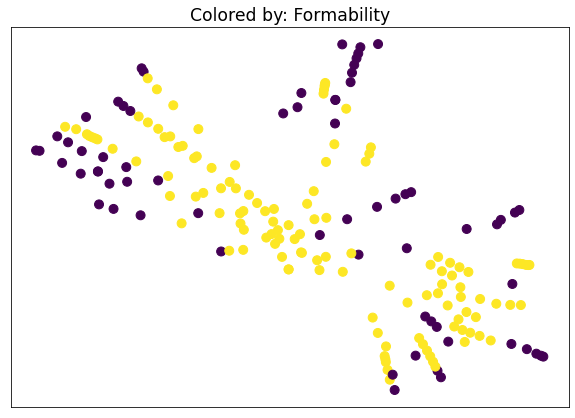

In [28]:
tsne = TSNE(n_components=2, perplexity=50, n_iter=1000, metric='euclidean', init='random',
    method='barnes_hut',n_jobs=-1)
%time X_embedded = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))   
plt.scatter(X_embedded[:,0], X_embedded[:,1],s=80,c=data_bin['Formability'])
plt.title('Colored by: Formability',fontsize='xx-large')
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
#plt.colorbar()
plt.savefig('tsne_formability.png',facecolor='white', transparent=False)

CPU times: user 5.3 s, sys: 98.9 ms, total: 5.4 s
Wall time: 770 ms


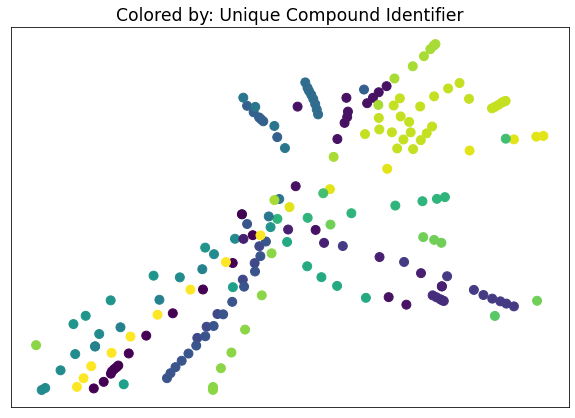

In [29]:
tsne = TSNE(n_components=2, perplexity=50, n_iter=1000, metric='euclidean', init='random',
    method='barnes_hut',n_jobs=-1)
%time X_embedded = tsne.fit_transform(X_scaled)
label = 'Int_Compound'
plt.figure(figsize=(10, 7))   
plt.scatter(X_embedded[:,0], X_embedded[:,1],s=80,c=df[label])
plt.title(f'Colored by: Unique Compound Identifier',fontsize='xx-large')
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
#plt.colorbar()
plt.savefig('tsne_compound.png',facecolor='white', transparent=False)

CPU times: user 4.34 s, sys: 136 ms, total: 4.47 s
Wall time: 642 ms


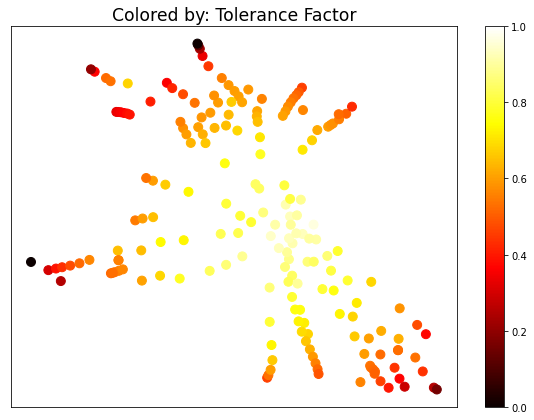

In [30]:
tsne = TSNE(n_components=2, perplexity=50, n_iter=1000, metric='euclidean', init='random',
    method='barnes_hut',n_jobs=-1)
%time X_embedded = tsne.fit_transform(X_scaled)
label = 'normalized_tol_factor'
plt.figure(figsize=(10, 7))  
plt.scatter(X_embedded[:,0], X_embedded[:,1],s=80,c=data_bin[label],cmap='hot')
plt.title(f'Colored by: Tolerance Factor',fontsize='xx-large')
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
plt.colorbar()
plt.savefig('tsne_tol_factor.png',facecolor='white', transparent=False)

---
## Model 3: New classification scheme
Let's try random forests and even something as simple as KNN
- [KNN](https://scikit-learn.org/stable/modules/neighbors.html)
- [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
- [Permutation Importance](

In [41]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import math

In [32]:
form = np.where(data_bin['Formability']==1)[0].size
print('Fraction of Formable compounds: ',form/data_bin.shape[0])

Fraction of Formable compounds:  0.6510416666666666


In [33]:
## KNN

# Define our models
knn = KNeighborsClassifier()
parameters = {'n_neighbors':np.linspace(1,10,1,dtype='uint8'),'weights':['uniform','distance']}
clf = GridSearchCV(knn,parameters)

# Split our data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=40,shuffle=True)

# get best hyperparameters
clf.fit(X_train,y_train)

## Inspect our hyperparameter optimizer
print('Best parameters: ', clf.best_params_)
print('Best score: ', clf.best_score_)

Best parameters:  {'n_neighbors': 1, 'weights': 'uniform'}
Best score:  0.6980645161290322


In [34]:
knn=KNeighborsClassifier(n_neighbors=1, weights='uniform')
knn.fit(X_train,y_train)

# Predict with test set
pred = knn.predict(X_test)

# record and return accuracy
wrong = np.count_nonzero(pred-y_test)
print('accuracy: ',1-(wrong/pred.size))

accuracy:  0.725


In [35]:
# Random Forest

# helper function to calculate score for both datasets
# thanks Dr. Verma
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_test), y_test),
                m.score(X_train, y_train), m.score(X_test, y_test)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    #print(res)
    return res

In [36]:
# let's use the same train test split as above

# define our model
m = RandomForestRegressor()
parameters = {'n_estimators':np.linspace(10,10000,3,dtype='uint8'),'max_depth':[5,10,50,100], 'min_samples_split':[2,5,10,20]}
clf = GridSearchCV(m,parameters)

# Split our data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=40,shuffle=True)

# get best hyperparameters
clf.fit(X_train,y_train)

print('Best parameters: ', clf.best_params_)
print('Best score: ', clf.best_score_)

Best parameters:  {'max_depth': 100, 'min_samples_split': 2, 'n_estimators': 141}
Best score:  0.5190840377973557


In [37]:
m = RandomForestRegressor(n_estimators=clf.best_params_['n_estimators'],max_depth=clf.best_params_['max_depth'], min_samples_split=clf.best_params_['min_samples_split'])
m.fit(X_train,y_train)
scores = print_score(m)
score_labels = ['rmse train: ', 'rmse test: ', 'accuracy train: ', 'accuracy test: ']
for score, label in zip(scores,score_labels):
    print(label,score)

rmse train:  0.2431954196430585
rmse test:  0.5975782320949018
accuracy train:  0.9359670451557903
accuracy test:  0.5748812577694424


In [42]:
## Lets take a look at feature importance


std = np.std([tree.feature_importances_ for tree in m.estimators_],axis=0)

result = permutation_importance(
    m, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(sorted(result.importances_mean,reverse=True), index=X.columns)

In [43]:
feature_names = [f"feature {i}" for i in X.columns]

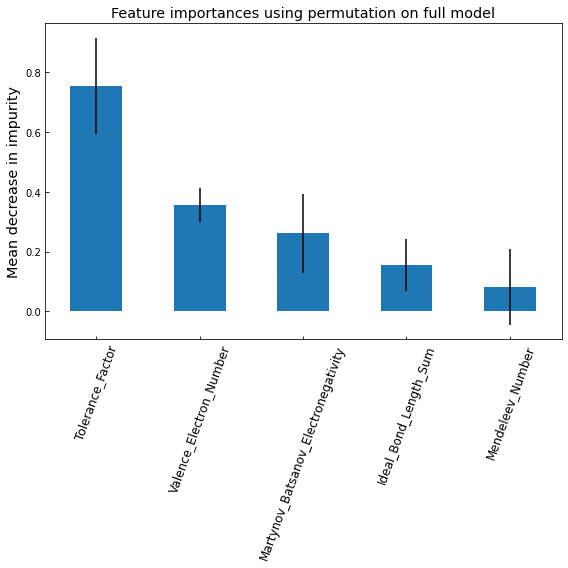

In [44]:
fig,ax = plt.subplots(figsize=(8,8))
forest_importances.plot.bar(yerr=std,ax=ax)
ax.set_title("Feature importances using permutation on full model",fontsize='x-large')
ax.set_ylabel("Mean decrease in impurity",fontsize='x-large')
#ax.set_xticklabels(ax.get_xticklabels,fontsize='xlarge')
ax.tick_params(which='both',direction='in')
ax.tick_params(axis='x',labelsize='large',rotation=70)
fig.tight_layout()
fig.savefig('Feature_importance_rf.png',facecolor='white', transparent=False)